### GYM Workout Visualization
By Han Sun

In [93]:
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib        as mpl
import numpy             as np

from itertools import cycle

mpl.rc( 'font', family = 'serif' )
mpl.rc( 'text', usetex = True    )

mpl.rcParams[ 'font.size'        ] = 12
mpl.rcParams[ 'axes.labelsize'   ] = 12
mpl.rcParams[ 'legend.fontsize'  ] = 12
mpl.rcParams[ 'legend.edgecolor' ] = 'k'
mpl.rcParams[ 'figure.facecolor' ] = 'w'
mpl.rcParams[ 'lines.linewidth'  ] = 1

cycol    = cycle('bgrcmyk')
cymarker = cycle('ov^')

#### the data loader: workout_data

In [94]:
class workout_data(object):
    
    def __init__( self, range_ ):
        # hard code format
        self.row_idx = {'Shoulder': list(range(0, 6)), 
                        'Back':     list(range(8, 15)), 
                        'Chest':    list(range(17, 26)), 
                        'Arm':      list(range(28, 39))}
        self.cycles = []*len(range_)
        # cycle through and store data
        for cycle_i in range_:
            cycle = {}
            cycle['idx'] = cycle_i
            sheet = pd.read_excel('GYM.xlsx', sheetname='Week#' + str(cycle_i) )
            for _, range_ in self.row_idx.items():
                part_block = sheet.iloc[range_, :]
                cycle[ part_block.iloc[0, 0] ] = part_block
            self.cycles.append(cycle) 
        #
        return
    
    def plot_body( self, part_names ):
        plt.figure(figsize=(10,6), dpi=250)
        ylim_max = 0
        #
        for part_name in part_names:
            X, y = [], []
            for cycle in self.cycles:
                part_block = cycle[part_name]
                X.append(part_block.iloc[1, 0])
                y.append( sum(part_block.iloc[:, -1]) )
            plt.plot(X, y, marker=next(cymarker), color=next(cycol), label=part_name)
            ylim_max = max(ylim_max, max(y)*1.2)
        #
        plt.ylim([0, ylim_max])        
        plt.ylabel('Total Volume, lb')
        plt.xlabel('Date')
        plt.legend(bbox_to_anchor=(1.3, 1))
        plt.xticks(rotation=70)
        plt.grid()
        plt.show()
        #
        return
    
    
    def plot_muscle_group( self, part_name, plot_type ):
        if plot_type == 'total volume':
            self._plot_muscle_group( part_name, plot_type, -1 )
        elif plot_type == 'set of weight':
            self._plot_muscle_group( part_name, plot_type, -3 )
        elif plot_type == 'number of set':
            self._plot_muscle_group( part_name, plot_type, -2 )
        elif plot_type == 'number of rep':
            self._plot_muscle_group( part_name, plot_type, -4 )
        else:
            print('invalid type')
            return
        
    def _plot_muscle_group( self, part_name, plot_type, idx_column ):
        plt.figure(figsize=(10,6), dpi=250)
        ylim_max = 0
        X = []
        num_practice = len(self.row_idx[part_name])
        Y = [[0]*len(self.cycles) for _ in range(num_practice)]
        #
        for i_cycle, cycle in enumerate(self.cycles):
            part_block = cycle[part_name]
            X.append(part_block.iloc[1, 0])
            for i_practice in range(num_practice):
                # only append data if practice is done
                if part_block.iloc[i_practice, -1] > 0:
                    Y[i_practice][i_cycle] = part_block.iloc[i_practice, idx_column]
        X = np.array(X)
        labels = list(part_block.iloc[:, 1])
        #
        for ii, y in enumerate(Y):
            ylim_max = max(ylim_max, max(y)*1.2)
            y = np.array(y)
            plot_index = [y_i != 0 for y_i in y]
            plt.plot(X[plot_index], y[plot_index], color=next(cycol),
                     label=labels[ii], marker=next(cymarker), linestyle=':')
        #
        plt.ylim([0, ylim_max])
        plt.ylabel(plot_type)
        plt.xlabel('Date')
        plt.legend(bbox_to_anchor=(1.1, 1))
        plt.xticks(rotation=70)
        plt.grid()
        plt.show()
        
        return
        

### Test out!

In [95]:
my_workout = workout_data(  range(1,10)  )

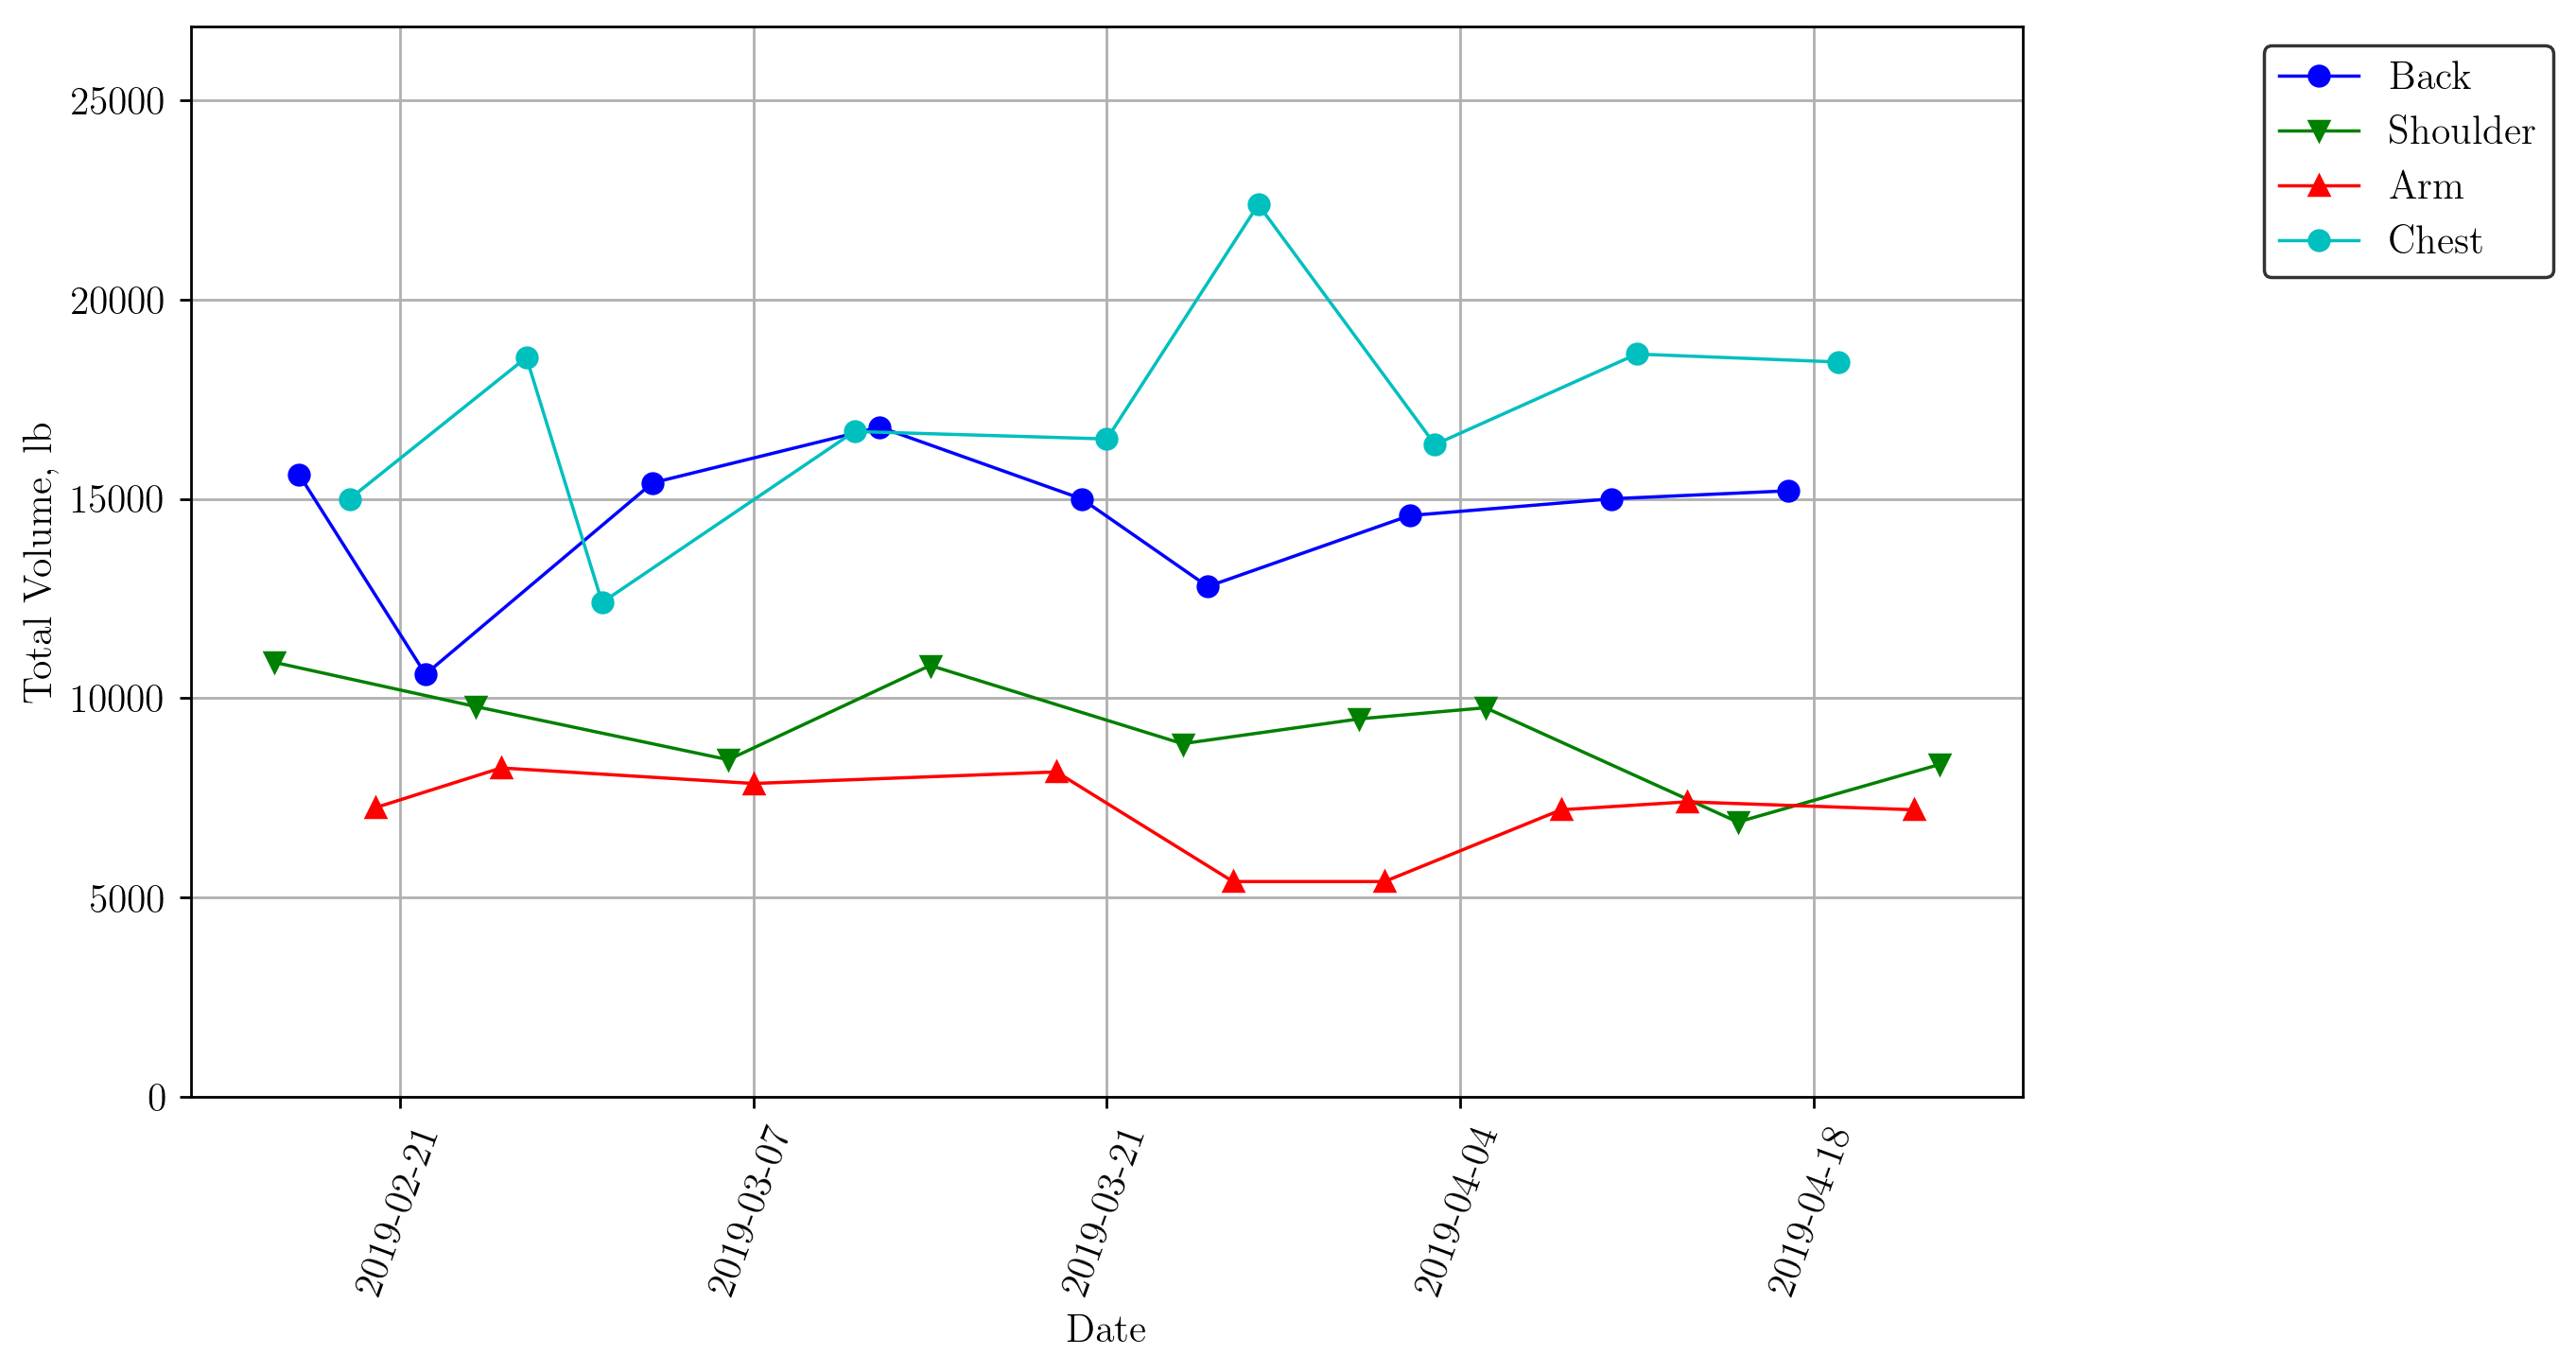

In [96]:
my_workout.plot_body( ['Back', 'Shoulder', 'Arm', 'Chest'] )

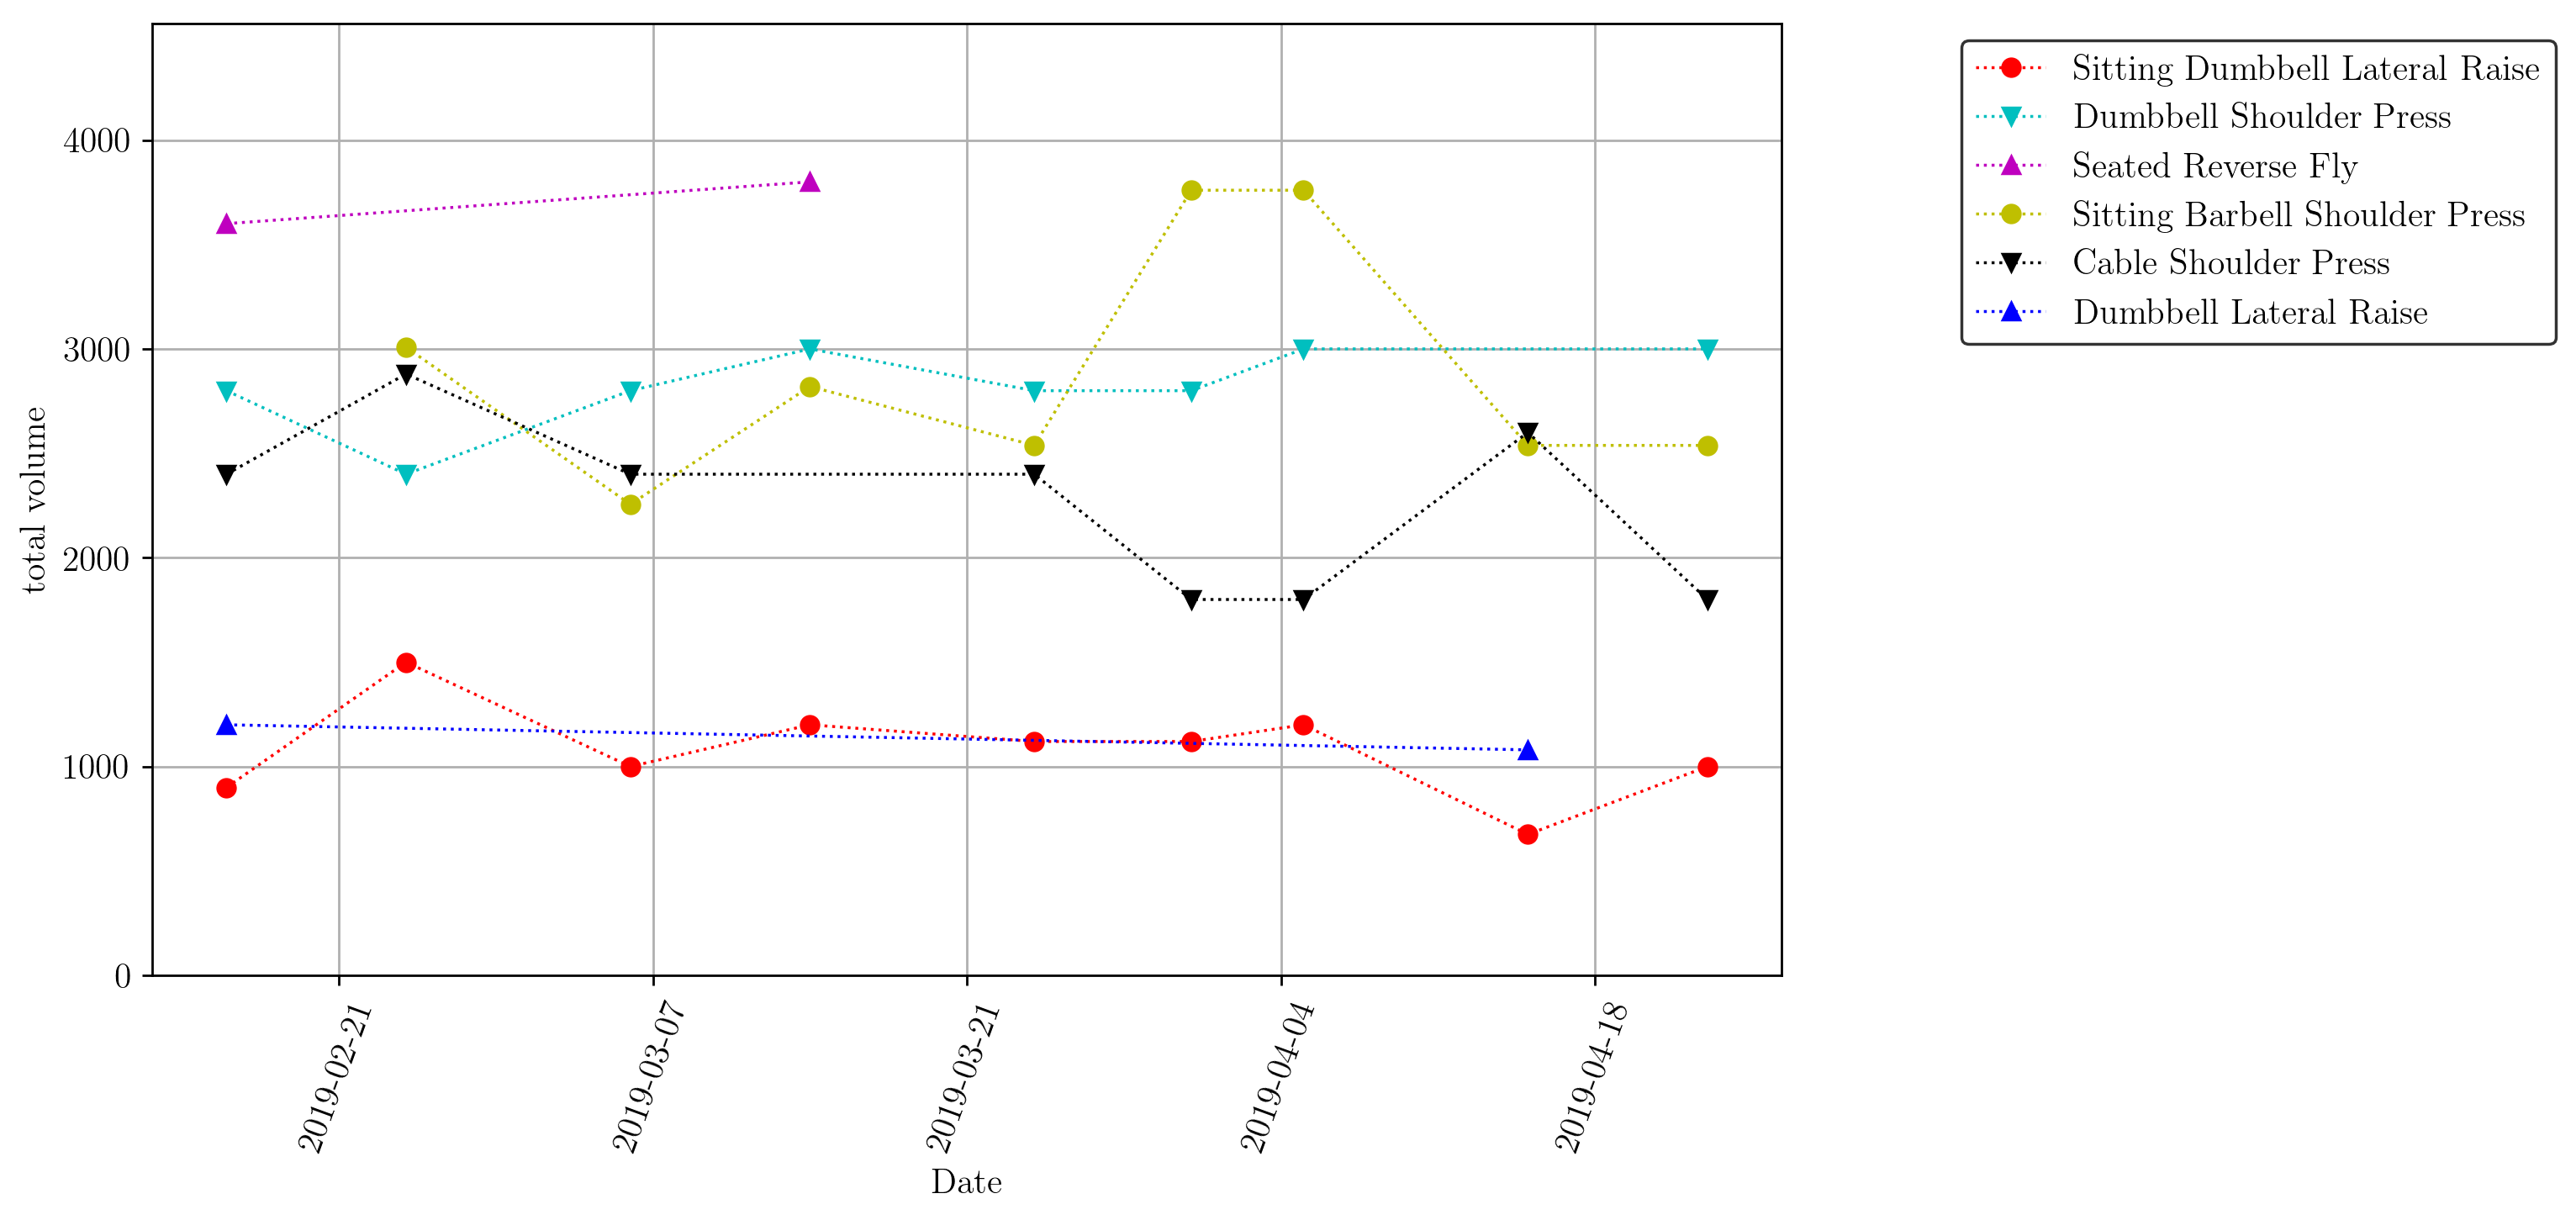

In [104]:
my_workout.plot_muscle_group( 'Shoulder', 'total volume' )

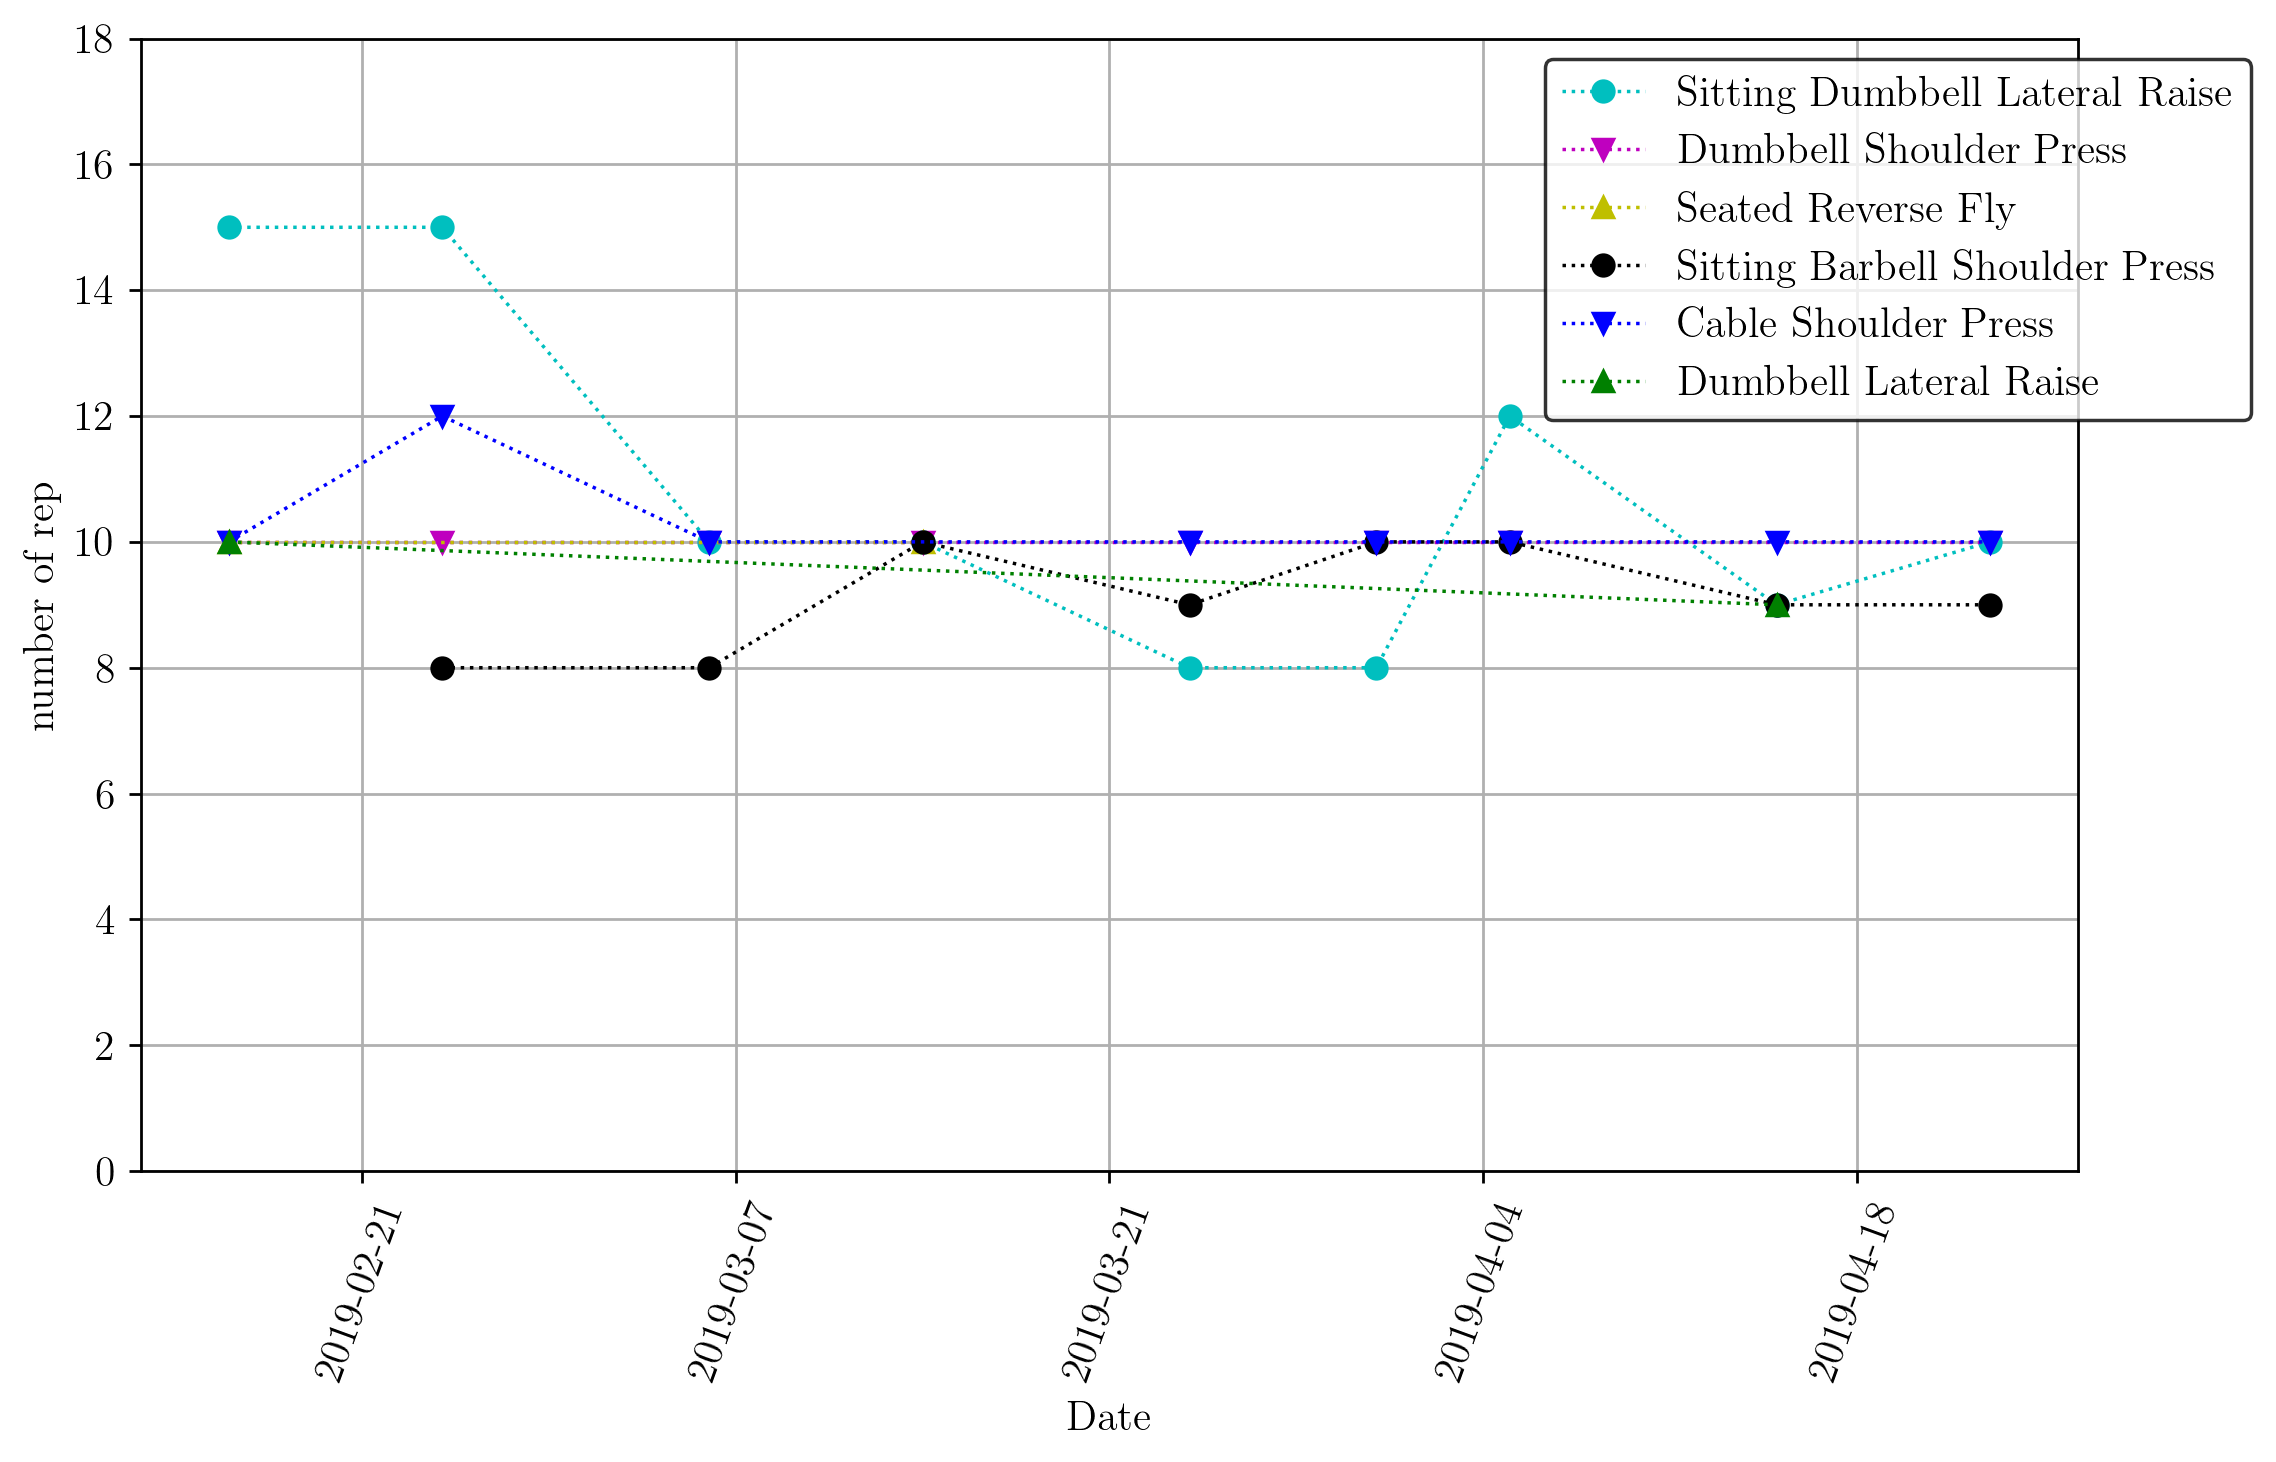

In [103]:
my_workout.plot_muscle_group( 'Shoulder', 'number of rep' )